[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/sub_daily_data_yosemite_temps.ipynb)

# Sub-daily data
NeuralProphet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the ds column. The format of the timestamps should be `YYYY-MM-DD HH:MM:SS` - see the example csv [here](https://github.com/ourownstory/neuralprophet-data/blob/main/datasets/yosemite_temps.csv). When sub-daily data are used, daily seasonality will automatically be fit. 

Here we fit NeuralProphet to data with 5-minute resolution (daily temperatures at Yosemite). 

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

df = pd.read_csv(data_location + "yosemite_temps.csv")

Now we will attempt to forecast the next 7 days. The `5min` data resulution means that we have `60/5*24=288` daily values. Thus, we want to forecast `7*288` periods ahead.

Using some common sense, we set:
* First, we disable weekly seasonality, as nature does not follow the human week's calendar.
* Second, we disable changepoints, as the dataset only contains two months of data

  0%|          | 0/313 [00:00<?, ?it/s]

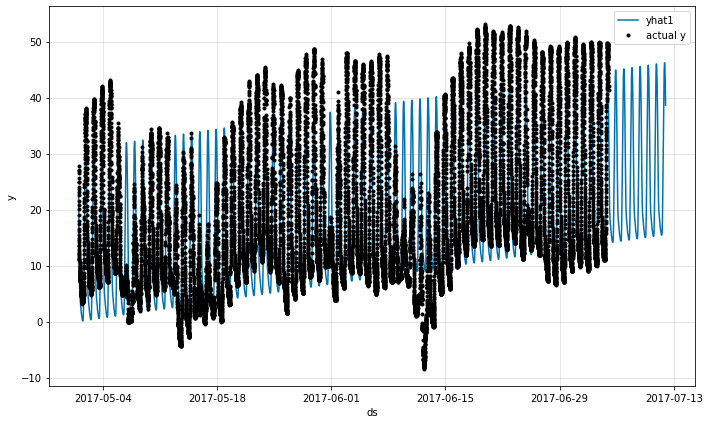

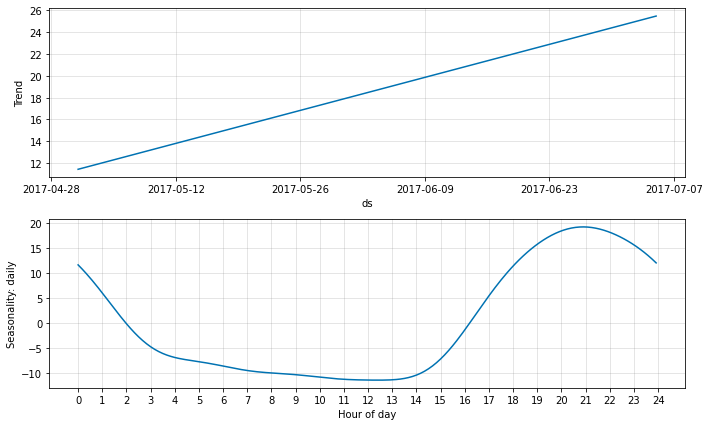

In [3]:
m = NeuralProphet(
    n_changepoints=0,
    weekly_seasonality=False,
)
metrics = m.fit(df, freq='5min')
future = m.make_future_dataframe(df, periods=7*288, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)
# fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

The daily seasonality seems to make sense, when we account for the time being recorded in GMT, while Yosemite local time is GMT-8.

## Improving trend and seasonality 
As we have `288` daily values recorded, we can increase the flexibility of `daily_seasonality`, without danger of overfitting. 

Further, we may want to re-visit our decision to disable changepoints, as the data clearly shows changes in trend, as is typical with the weather. We make the following changes:
* increase the `changepoints_range`, as the we are doing a short-term prediction
* inrease the `n_changepoints` to allow to fit to the sudden changes in trend
* carefully regularize the trend changepoints by setting `trend_reg` in order to avoid overfitting

  0%|          | 0/313 [00:00<?, ?it/s]

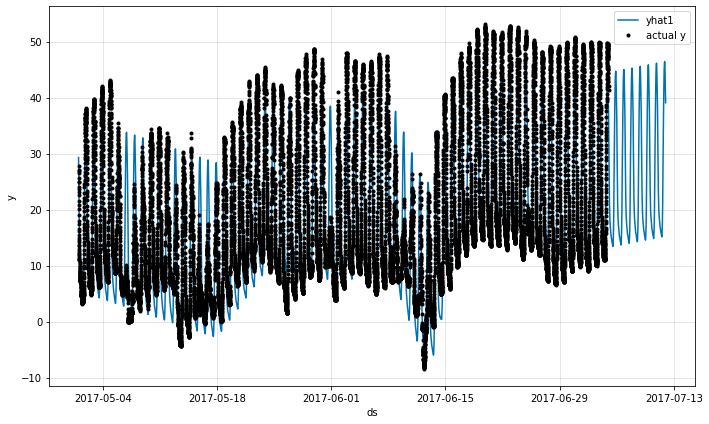

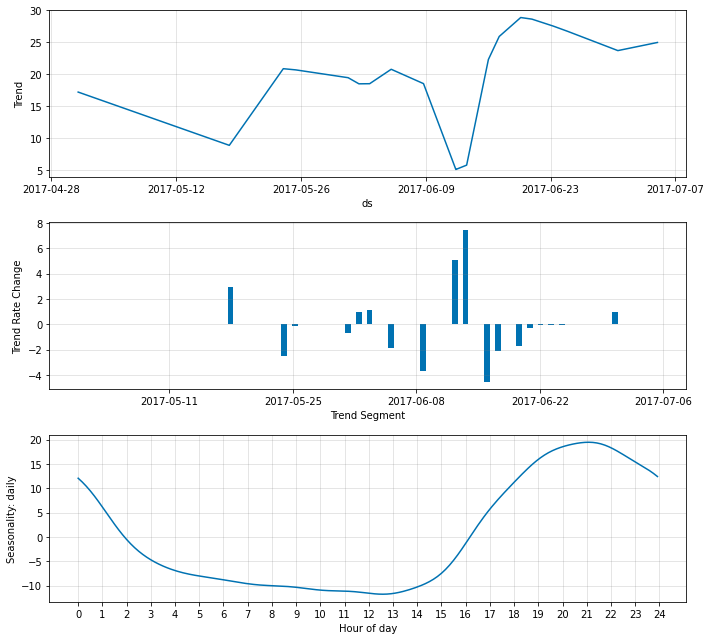

In [6]:
m = NeuralProphet(
    changepoints_range=0.95,
    n_changepoints=50,
    trend_reg=1,
    weekly_seasonality=False,
    daily_seasonality=10,
)
metrics = m.fit(df, freq='5min')
future = m.make_future_dataframe(df, periods=60//5*24*7, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)
# fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()